In [25]:
import meld_graph
import meld_graph.models
import meld_graph.experiment
import meld_graph.dataset
import meld_graph.data_preprocessing
import meld_graph.evaluation


import importlib
importlib.reload(meld_graph)
importlib.reload(meld_graph.models)
importlib.reload(meld_graph.dataset)
importlib.reload(meld_graph.experiment)
importlib.reload(meld_graph.data_preprocessing)
importlib.reload(meld_graph.evaluation)

import logging
import os
import json

from meld_graph.dataset import GraphDataset, Oversampler
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
from meld_graph.training import Metrics
import numpy as np
from meld_graph.paths import EXPERIMENT_PATH

from meld_graph.evaluation import Evaluator



### testing the class

In [26]:
EXPERIMENT_PATH='/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1'
checkpoint_path=os.path.join(EXPERIMENT_PATH, '22-07-29_synth_3layer/finetune_radius0.2/fold_00')
# checkpoint_path=os.path.join(EXPERIMENT_PATH, '22-08-19_synth_unet_gamma_2_synthetic_data__bias/synthetic_data__bias_1/fold_00')
exp = meld_graph.experiment.Experiment.from_folder(checkpoint_path)
eva = Evaluator(experiment = exp,
                checkpoint_path = checkpoint_path,
                test_parameters = "../scripts/config_files/experiment_config_mr.py",
                save_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/22-08-18_synth_eva',
                make_images = True,
                #subject_ids=['MELD_H10_3T_FCD_0001', 'MELD_H10_3T_FCD_0002', 'MELD_H10_3T_FCD_0003', 'MELD_H10_3T_FCD_0004']
               )


Initialised Experiment 22-08-01_synth_eva
Evalution test, 0.5
getting train val test split
total number of subjects: 45
total number of subjects after restricting to subjects from MELD_dataset_V6_test.csv: 9
total number of subjects: 950
total number of subjects after restricting to subjects from MELD_dataset_V6_test.csv: 9
total number after filtering by scanner ['3T', '15T'], features, lesional_only True: 9
full_feature_list: ['.combat.on_lh.curv.sm5.mgh', '.combat.on_lh.pial.K_filtered.sm20.mgh', '.combat.on_lh.sulc.sm5.mgh', '.combat.on_lh.thickness.sm10.mgh', '.combat.on_lh.w-g.pct.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh', '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh', '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.inter_z.intr

conv 2 16
conv 16 16
conv 16 16


loading data and predicting model
Loading and preprocessing data
Combine hemis None
Using coord type pseudo


FileNotFoundError: [Errno 2] No such file or directory: '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1/22-08-18_subj_eval/results/images/MELD_H10_3T_FCD_0001.jpg'

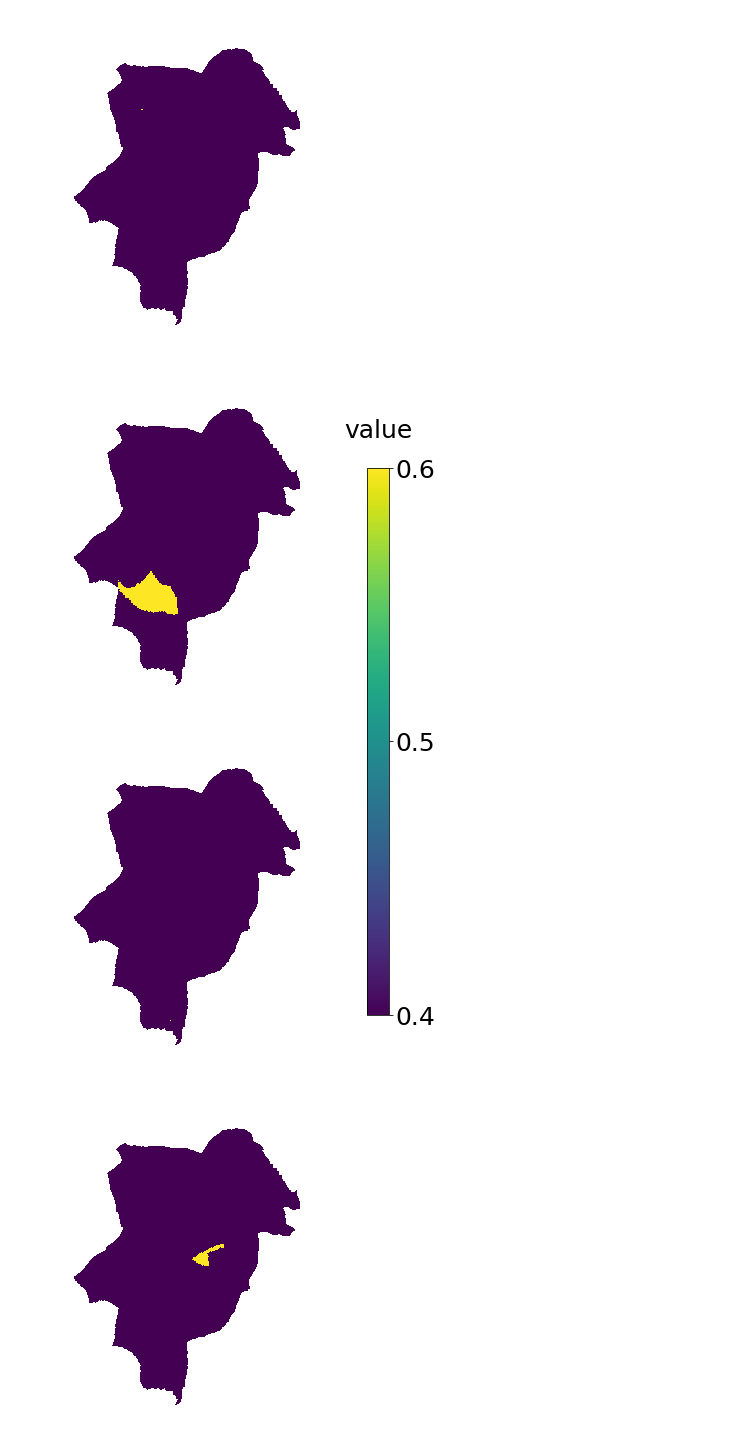

In [27]:
eva.evaluate()

In [ ]:
data_loader = eva.load_predict_data()

## Evaluation using baseline model

In [ ]:
config = load_config("../scripts/config_files/experiment_config_mr.py")
print(config.data_parameters)
print(config.network_parameters)

In [ ]:
config.network_parameters['name'] += '/test_eval'
config.network_parameters['training_parameters']['init_weights'] = 'finetune_radius0.2/fold_00/best_model.pt'
print(config.network_parameters['name'])

In [ ]:
exp = meld_graph.experiment.Experiment(config.network_parameters, config.data_parameters, verbose=logging.INFO)

In [ ]:
# 
import torch
exp.load_model(checkpoint_path='/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-07-29_synth_3layer/finetune_radius0.2/fold_00/best_model.pt', 
               force=True )

In [ ]:
# create dataset for evaluation
from meld_graph.dataset import GraphDataset
from meld_classifier.meld_cohort import MeldCohort

# initiate params
subjects = []
features = ['.combat.on_lh.thickness.sm10.mgh',
        '.combat.on_lh.pial.K_filtered.sm20.mgh',]

params = {                
          'combine_hemis': None,
          'lobes': False,
          'features':features,
          "preprocessing_parameters": {
                    "scaling": None,
                    },
          "augment_data": {},
          "lesion_bias": 10,
          'synthetic_data': {
            'n_subs': 100,
            #amount of bias
            'bias': 0.5,
            #mean radii of lesions
            'radius':0.5,
            'n_subtypes':5,
                },
     'metrics': ['dice_lesion', 'dice_nonlesion', 'precision', 'recall', 'tp', 'fp', 'fn', 'tn', 'sensitivity'],
         }


cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix.hdf5')
dataset = GraphDataset(subjects, cohort, params )

In [ ]:
data_loader = torch_geometric.loader.DataLoader(dataset,
            shuffle=False, )

In [ ]:
#predict 
import torch_geometric.data
from meld_graph.training import Metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_loader = torch_geometric.loader.DataLoader(dataset,
            shuffle=False, batch_size=2)
metrics = Metrics(params['metrics'])  # for keeping track of running metrics
for data in data_loader:
    print('loader')
    data = data.to(device)
    estimates = exp.model(data.x)
    labels = data.y.squeeze()   
    # metrics
    pred = torch.argmax(estimates[0], axis=1)
    # update running metrics
    metrics.update(pred, labels)

metrics.get_aggregated_metrics()

In [ ]:
#plot lesion
import matplotlib_surface_plotting as msp
from meld_graph.icospheres import IcoSpheres

#initialise the icosphere
icos=IcoSpheres(conv_type='SpiralConv')
ico_index=7
ico_ini = icos.icospheres[ico_index]

#plot example of feature on icosphere for 1 subject
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              pred.numpy()[0:163842], 
              parcel=labels.numpy()[0:163842], 
              parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[50,250], 
                 )


In [ ]:
#plot lesion
import matplotlib_surface_plotting as msp
from meld_graph.icospheres import IcoSpheres

#initialise the icosphere
icos=IcoSpheres(conv_type='SpiralConv')
ico_index=7
ico_ini = icos.icospheres[ico_index]

#plot example of feature on icosphere for 1 subject
index = 3
feat=1
features_subj, labels_subj = dataset.data_list[index]
msp.plot_surf(ico_ini['coords'],
              ico_ini['faces'],
              features_subj[:,feat], 
              parcel=labels_subj, 
              parcel_cmap={1:[1,0,0,0]},
              colorbar=False, rotate=[150,250], 
                 )


In [ ]:
len(dataset.data_list)

In [ ]:
lesions=[]
for i in range(0, len(dataset.data_list)):
    data_sub=dataset.data_list[i]
    lesions.append(data_sub[1])

In [ ]:
np.unique(lesions, axis=0)

In [ ]:
features_subj0, labels_subj0 = dataset.data_list[0]
features_subj1, labels_subj1 = dataset.data_list[1]

In [ ]:
(features_subj0==features_subj1).all()